# Visualization for Overview

## Attributes to Measure Efficiency of the Visualization

Let's use Radar Chart with 4~6 axis

4~6 attributes 
1. time
2. # of fixations
3. avg fix duration
4. scan path
5. area of convex hull
6. avg pupil dilation
7. # of clicks

*all in average(mean) for the group of participants*


### Data needed for each participant

- [x] time
  - time on task
    - from `Others/participant_data.js`

- [x] # of fixations
  - last fixation's serial number
- [x] avg fix duration
  - calculate average durations
    - fixation data from `Raw_Data/p1/p1.treeFXD.txt, Raw_Data/p1/p1.graphFXD.txt, Raw_Data/p2/p2.treeFXD.txt, Raw_Data/p2/p2.graphFXD.txt, ...`
  
- [x] scan path
  - calculate saccadic length between each fixations
  - add all saccadic length up
- [x] avg saccadic length
  - get avg of all saccadic length
      - fixation data from `Raw_Data/... p1/p1.treeFXD.txt, p1/p1.graphFXD.txt, p2/p2.treeFXD.txt, p2/p2.graphFXD.txt, ...`

- [ ] avg pupil dilation
  - [ ] avg baseline (b/c of different base pupil sizes depend on ppl's eyes and conditions)
    - baseline data from `Raw_Data/p1/p1GZD.txt, Raw_Data/p2/p2GZD.txt, ...`
  - [ ] avg left, right pupil size throughout the task
    - gaze data from `filtered_data/... p1/p1treeGZD.js, p1/p1graphGZD.js, p2/p1treeGZD.js, ...`
  
- [x] area of convex hull
  - calculate it using [scipy.spatial.ConvexHull](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html)
    - fixation from `Raw_Data/... p1/p1.treeFXD.txt, p1/p1.graphFXD.txt, p2/p2.treeFXD.txt, p2/p2.graphFXD.txt, ...`
  
- [ ] # of clicks
  - count the total 'LMouseButton' events
    - event data from `Raw_Data/... p1/p1.treeEVD.txt, p1/p1.graphEVD.txt, p2/p2.treeEVD.txt, p2/p2.graphEVD.txt, ...`
    

### Final output planned
for example...
1. overview_participant.csv
```
pid,ont_type,vis_type,session_type,time,success,totalfix,avg_fix_duration,scanpath,avg_saccadic_length,avg_pupil_dilation,convexhull_area,totalclick
p1,1,1,1,26,0.608695652,2647,140,10000,20,1.2,1000,606
p1,2,2,4,38,0.52173913,2422,200,20000,10,2.0,1200,984
p2,1,2,3,19,0.347826087,2581,,,,,,416
p2,2,1,2,25,0.391304348,1166,,,,,,371
p3,1,1,1,10,0.47826087,1564,,,,,,173
p3,2,2,4,50,0.391304348,7967,,,,,,891
p4,1,2,3,12,0.391304348,590,,,,,,235
p4,2,1,2,9,0.52173913,605,,,,,,254
```
2. overview_combined.csv
```
sessionID,ont_type,vis_type,m_time,m_success,m_totalfix,m_avg_fix_duration,m_scanpath,m_avg_saccadic_length,m_avg_pupil_dilation,m_convexhull_area,m_totalclick
1,general,tree,18,0.5,2000,,,,,,490
2,expert,tree,17,0.45,850,,,,,,310
3,general,graph,15.5,0.37,1500,,,,,,300
4,expert,graph,44,0.45,5000,,,,,,930
```

#### Field info

ontology type:
1. general
2. expert

visualization type:
1. tree
2. graph

session type:
1. general - tree
3. expert - tree
2. general - graph
4. expert - graph


## Import libraries

In [151]:
#importing necessary libraries
import pandas as pd
import os
import glob
from math import sqrt
from statistics import mean
from scipy.spatial import ConvexHull

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import warnings
warnings.filterwarnings("ignore")


## Loading the data

## 1. ont_type, vis_type, time, success

In [72]:
df = pd.read_json ('tweakedData/participant_data.json')
# df.rename(columns = {'P_ID':'pid', 
#                      'Ontology': 'ont_type', 
#                      'Visualization': 'vis_type', 
#                      'Session_Type': 'session_type', 
#                      'Time_On_Task': 'time',
#                      'Task_Success': 'success'}, inplace = True)
df = df[['P_ID','Ontology','Visualization','Session_Type','Time_On_Task','Task_Success']]
df.head(5)

,P_ID,Ontology,Visualization,Session_Type,Time_On_Task,Task_Success
0,p1,1,1,1,26,0.608696
1,p1,2,2,4,38,0.521739
2,p3,1,1,1,10,0.478261
3,p3,2,2,4,50,0.391304
4,p5,1,1,1,22,0.521739


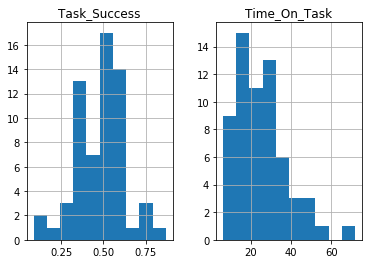

In [73]:
df[['Task_Success','Time_On_Task']].hist();

## 2. totalfix, avg_fixation_duration

## 2-1. Work with multiple fixation files
Combine all???

In [174]:
dirPath = '../Raw_Data/'
FXD_filenames = [i for i in glob.glob(dirPath+'p*/p*.*FXD.txt')]

In [165]:
fix_dfs = pd.concat([pd.read_csv(f, sep="\t", header=None) for f in FXD_filenames])
fix_dfs.rename(columns = {0:'number', 
                     1: 'timestamp', 
                     2: 'duration', 
                     3: 'x', 
                     4: 'y'}, inplace = True)
fix_dfs.head()


,number,timestamp,duration,x,y
0,1,475,100,632,405
1,2,4084,100,285,197
2,3,4622,339,72,208
3,4,7792,199,304,978
4,5,8490,120,389,915


In [166]:
print ('total data count :', len(fix_dfs.index))

total data count : 193536


But, I don't want to use this smashed one.  
The attributes I want to use should be calculated for each fixation file.  
Then...

## 2-2. Let's test the process with one fixation file first

In [95]:
# testing with one fixation file
p1_treeFXD_df = pd.read_csv(dirPath+"p1/p1.treeFXD.txt", sep = "\t", header=None)

p1_treeFXD_df.rename(columns = {0:'number', 
                     1: 'timestamp', 
                     2: 'duration', 
                     3: 'x', 
                     4: 'y'}, inplace = True)
p1_treeFXD_df.head()

# p1_treeFXD_df.set_index('number', inplace = True)  # set 'number'column as a key
# p1_treeFXD_df[['duration']].head()  # can get dataframe only with the selected column

,number,timestamp,duration,x,y
0,1,2027,100,1005,60
1,2,7968,319,78,237
2,3,8526,100,246,207
3,4,9105,140,298,198
4,5,9962,140,909,1002


In [97]:
p1_treeFXD_df['saccadic_length'] = 0  # can add a new column and assign value this way
p1_treeFXD_df.head()

,number,timestamp,duration,x,y,saccadic_length
0,1,2027,100,1005,60,0
1,2,7968,319,78,237,0
2,3,8526,100,246,207,0
3,4,9105,140,298,198,0
4,5,9962,140,909,1002,0


In [112]:
# function to calculate distance between two points
def calculateDistance(x1,y1,x2,y2):
     d = sqrt((x2 - x1)**2 + (y2 - y1)**2)
     return d

In [172]:
# Function to return array of distances from array of points
def getDistances(points):
    distances = []
    for i in range(len(points['x'])):
        if i == 0:
            distances.append(None)
            continue
        x1 = points.loc[i-1,'x']
        y1 = points.loc[i-1,'y']
        x2 = points.loc[i,'x']
        y2 = points.loc[i,'y']
        distances.append(calculateDistance(x1,y1,x2,y2))
    return distances

saccadicLengths = getDistances(p1_treeFXD_df)
saccadicLengths[:5]

[None,
 943.7467880740045,
 170.6575518399347,
 52.773099207835045,
 1009.8202810401463]

### Average Saccadic Length

In [170]:
# Function to get average saccadic length from fixation datafram
def getAvgSaccadicLength(fixdf):
    saccadicLengths = getDistances(fixdf)
    return mean( filter(None, saccadicLengths) )

AvgSaccadicLength = getAvgSaccadicLength(p1_treeFXD_df)
print ("AvgSaccadicLength is :", round(AvgSaccadicLength,2))

AvgSaccadicLength is : 160.96


### Scan Path

In [171]:
# Function to get scanpath from fixation dataframe
def getScanpath(fixdf):
    saccadicLengths = getDistances(fixdf)
    return sum( filter(None, saccadicLengths) )

Scanpath = getScanpath(p1_treeFXD_df)
print ("Scanpath is :", round(Scanpath,2))

Scanpath is : 425894.36


### Area of Convex Hull

In [169]:
# Function to get area of convex hull from fixation dataframe
def getConvexHullArea(fixdf):
    points = fixdf[['x','y']]
    S = ConvexHull(points).area
    V = ConvexHull(points).volume
    print ("S :", S)
    print ("V :", V)
    return S

ConvexHullArea = getConvexHullArea(p1_treeFXD_df)
print ("Area of ConvexHull :", ConvexHullArea)

S : 3724.835369425075
V : 956959.9999999999
Area of ConvexHull : 3724.835369425075


### Total Fixations

In [163]:
def getTotalFixations(fixdf):
    return len(fixdf.index)

TotalFix = getTotalFixations(p1_treeFXD_df)
print ("TotalFix :", TotalFix)

TotalFix : 2647


### Average Fixation Duration

In [168]:
def getAvgDuration(fixdf):
    return round( mean( filter(None, fixdf['duration']) ) )

AvgDuration = getAvgDuration(p1_treeFXD_df)
print ("AvgDuration :", AvgDuration)

AvgDuration : 152


### Pupil Dilation
Average pupil size - Baseline 

### Baseline
Get average pupil sizes from baseline gaze data `p*/p*GZD.txt`

### Average Pupil Size
Get average left&right pupil sizes from gaze data `p*/p**GZD.txt`

In [213]:
def prepGZD(gzdf):
    gzdf.rename(columns ={0:'timestamp', 
                     1: 'number', 
                     2: 'screen_x_left', 
                     3: 'screen_y_left', 
                     4: 'cam_x_left',
                     5:'cam_y_left',
                     6:'distance_left',
                     7:'pupil_left',
                     8:'code_left', 
                    9:'screen_x_right', 
                    10:'screen_y_right',
                    11:'cam_x_rigth',
                    12:'cam_y_right',
                    13:'distance_right', 
                    14:'pupil_right', 
                    15:'code_right'},inplace = True)
    # drop unnecessary columns (only keep useful columns)
    gzdf = gzdf[['number','timestamp','pupil_left','code_left','pupil_right','code_right']]

    # clean invalid data (only keep valid ones) based on validity code
    print ('raw data count:', len(gzdf.index))
    gzdf = gzdf.loc[((gzdf['code_left'] == 0) & (gzdf['code_right'] == 0))]
    print ('after cleaning invalid:', len(gzdf.index))
    
    # clean negative pupil size (only keep positive pupil size)
    gzdf = gzdf.loc[((gzdf['pupil_left'] > 0) & (gzdf['pupil_right'] > 0))]
    print ('after cleaning negative:', len(gzdf.index))
    
    # drop validity code columns
    gzdf = gzdf.drop(['code_left','code_right'], axis = 1)
    
#     gzdf['pupilsize'] = gzdf[['pupil_left','pupil_right']]
    gzdf['pupilsize'] = gzdf.apply(lambda row: mean(row.pupil_left,row.pupil_right), axis = 1)
    
    return gzdf

p1_treeGZD_df = prepGZD(p1_treeGZD_df)
p1_treeGZD_df.head()
# p1_treeGZD_df.describe()
    

KeyError: "['code_left', 'code_right'] not in index"

In [ ]:
# process baseline data
p1_baseGZD_df =  pd.read_csv(dirPath+"p1/p1GZD.txt", sep = "\t", header=None)
# p1_baseGZD_df.head()

# process pupil size data
p1_treeGZD_df = pd.read_csv(dirPath+"p1/p1.treeGZD.txt", sep = "\t", header=None)
# p1_treeGZD_df.head()


### Total Clicks
Count 'LMouseButton' event from event data `p*/p**EVD.txt`

In [177]:
#process event data
p1_treeEVD_df = pd.read_csv("../Raw_Data/p1/p1.treeEVD.txt", sep = "\t", header=None)

# def prepEVD(evdf):
#     evdf.rename(columns = {0:'time', 
#                      1: 'event', 
#                      2: 'event_key', 
#                      3: 'data1', 
#                      4: 'data2',
#                      5:'description'}, inplace = True)
#     return evdf

# p1_treeEVD_df = prepEVD(p1_treeEVD_df)
p1_treeEVD_df.head()
# def get

ParserError: Error tokenizing data. C error: Expected 6 fields in line 439, saw 7
